In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

In [ ]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
data_dir = '/content/gdrive/MyDrive/new (1)/Kazakhstan_Banknotes_Dataset (1)/out_dir/'

In [ ]:
ls '/content/gdrive/MyDrive/new (1)/Kazakhstan_Banknotes_Dataset (1)/out_dir/'

10000_tenge/  1000_tenge/  20000_tenge/  2000_tenge/  5000_tenge/  500_tenge/


In [ ]:
from glob import glob
images = glob(os.path.join(data_dir, '*/*.jpg'))
tot_images = len(images)
print('Total images:', tot_images)

Total images: 1259


In [ ]:
tot_images = 1259
im_cnt = []
class_names = []
print('{:18s}'.format('Class'), end='')
print('Count')
print('-' * 24)
for folder in os.listdir(os.path.join(data_dir)):
    folder_num = len(os.listdir(os.path.join(data_dir, folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
    if (folder_num < tot_images):
        tot_images = folder_num
        folder_num = folder

num_classes = len(class_names)
print('Total number of classes: {}'.format(num_classes))

Class             Count
------------------------
500_tenge            210
1000_tenge           210
2000_tenge           210
5000_tenge           210
10000_tenge          209
20000_tenge          210
Total number of classes: 6


In [ ]:
data_transforms ={
    "train_transforms": transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])]),
   "valid_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])]),
    "test_transforms": transforms.Compose([transforms.Resize(225),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])
}

In [ ]:
# Split the dataset into train, validation and test
train_data = 0.8
valid_data = 0.2
test_data = 0.0

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir, transform=data_transforms["train_transforms"])#loading dataset
valid_data = datasets.ImageFolder(data_dir, transform=data_transforms["valid_transforms"])
test_data = datasets.ImageFolder(data_dir, transform=data_transforms["test_transforms"])

# Obtain training indices that will be used for validation and test
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
train_count = int(0.8*num_train)
valid_count = int(0.2*num_train)
test_count = num_train - train_count - valid_count
train_idx = indices[:train_count]
valid_idx = indices[train_count:train_count+valid_count]
test_idx = indices[train_count+valid_count:]

print(len(train_idx), len(valid_idx), len(test_idx))
print("Training", train_count, np.sum(len(train_idx)/num_train))
print("Validation", valid_count, np.sum(len(valid_idx)/num_train))
print("Test", test_count, np.sum(len(test_idx)/num_train))


1007 251 1
Training 1007 0.7998411437648928
Validation 251 0.1993645750595711
Test 1 0.0007942811755361397


In [ ]:
# Define a custom sampler for the dataset loader avoiding recreating the dataset (just creating a new loader for each different sampling)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

In [ ]:
# Define the dataloaders using the image datasets. Dataloader is used to load our data in batches
trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size = 32, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 32, sampler = test_sampler)

In [ ]:
classes = ["500_tenge", "1000_tenge", "2000_tenge", "5000_tenge", "10000_tenge", "20000_tenge"]

In [ ]:
#helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    plt.imshow(np.transpose(img, (1,2,0))) #convert tensor image type to numpy image type for visualization


In [ ]:
# #Visualize some sample data
# #Obtain one batch of training images
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# images = images.numpy() #convert images to numpy for display

# #Plot the images in the batch, along with corresponding labels
# fig = plt.figure(figsize=(25,4))
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#     imshow(images[idx])
#     #ax.set_title(str(labels[idx].item()))
#     ax.set_title(classes[labels[idx]])

In [ ]:
# Specify model architecture
# Load the pretrained model from pytorch's library and stored it in model_transfer
model_transfer = models.googlenet(pretrained=True)

# Check if GPU is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 62.7MB/s]


In [ ]:
#print the model to see all the layers
# print(model_transfer)

In [ ]:
#Lets read the fully connected layer
print(model_transfer.fc.in_features)
print(model_transfer.fc.out_features)

1024
1000


In [ ]:
for param in model_transfer.parameters():
    param.requires_grad=True

In [ ]:
# Define n_inputs takes the same number of inputs from pre-trained model
n_inputs = model_transfer.fc.in_features #refer to the fully connected layer only

# Add last linear layer (n_inputs -> 4 classes). In this case the ouput is 4 classes
# New layer automatically has requires_grad = True
last_layer = nn.Linear(n_inputs, len(classes))

model_transfer.fc = last_layer

# If GPU is available, move the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

# Check to see the last layer produces the expected number of outputs
print(model_transfer.fc.out_features)

6


In [ ]:
# Specify loss function and optimizer
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.001)

In [ ]:
# Train the model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''returns trained model'''
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.inf

    for epoch in range(1, n_epochs+1):
        # In the training loop, I track down the loss
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        # Model training
        model.train()
        for batch_idx, (data,target) in enumerate(trainloader):
            # 1st step: Move to GPU
            if use_cuda:
                data,target = data.cuda(), target.cuda()

            # Then, clear (zero out) the gradient of all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Perform the Cross Entropy Loss. Calculate the batch loss.
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform optimization step (parameter update)
            optimizer.step()
            # Record the average training loss
            train_loss = train_loss + ((1/ (batch_idx + 1 ))*(loss.data-train_loss))

        # Model validation
        model.eval()
        for batch_idx, (data,target) in enumerate(validloader):
            # Move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # Update the average validation loss
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the batch loss
            loss = criterion(output, target)
            # Update the average validation loss
            valid_loss = valid_loss + ((1/ (batch_idx +1)) * (loss.data - valid_loss))

        # print training/validation stats
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch,
            train_loss,
            valid_loss))

        # Save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.5f} --> {:.5f}). Saving model ...'.format(
                  valid_loss_min,
                  valid_loss))
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss

    # Return trained model
    return model

# Define loaders transfer
loaders_transfer = {'train': trainloader,
                    'valid': validloader,
                    'test': testloader}

# Train the model
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.54389 	Validation Loss: 0.78668
Validation loss decreased (inf --> 0.78668). Saving model ...
Epoch: 2 	Training Loss: 0.15647 	Validation Loss: 1.57511
Epoch: 3 	Training Loss: 0.14160 	Validation Loss: 0.14793
Validation loss decreased (0.78668 --> 0.14793). Saving model ...
Epoch: 4 	Training Loss: 0.11632 	Validation Loss: 0.05334
Validation loss decreased (0.14793 --> 0.05334). Saving model ...
Epoch: 5 	Training Loss: 0.09719 	Validation Loss: 0.01537
Validation loss decreased (0.05334 --> 0.01537). Saving model ...
Epoch: 6 	Training Loss: 0.05698 	Validation Loss: 0.01520
Validation loss decreased (0.01537 --> 0.01520). Saving model ...
Epoch: 7 	Training Loss: 0.06318 	Validation Loss: 0.03391
Epoch: 8 	Training Loss: 0.05909 	Validation Loss: 0.05455
Epoch: 9 	Training Loss: 0.04127 	Validation Loss: 0.00355
Validation loss decreased (0.01520 --> 0.00355). Saving model ...
Epoch: 10 	Training Loss: 0.07776 	Validation Loss: 0.00163
Validation loss d

In [ ]:
# import matplotlib.pyplot as plt

# # Plot the training and validation accuracy
# plt.plot(train_accuracy, label='Train Accuracy')
# plt.plot(valid_accuracy, label='Validation Accuracy')

# # Add labels and title
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')

# # Add legend
# plt.legend()

# # Show the plot
# plt.show()


In [ ]:
# Load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))


<All keys matched successfully>

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model_transfer.eval() #set model into evaluation/testing mode. It turns of drop off layer
    #Iterating over test data
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.000067


Test Accuracy: 100% ( 1/ 1)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate(model, dataloader, use_cuda):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataloader:
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            _, preds = torch.max(output, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    confusion = confusion_matrix(all_labels, all_preds)

    return accuracy, precision, recall, f1, confusion


In [ ]:
# After training, evaluate on the train, validation, and test sets
train_accuracy, train_precision, train_recall, train_f1, train_confusion = evaluate(model_transfer, trainloader, use_cuda)
validation_accuracy, validation_precision, validation_recall, validation_f1, validation_confusion = evaluate(model_transfer, validloader, use_cuda)
test_accuracy, test_precision, test_recall, test_f1, test_confusion = evaluate(model_transfer, testloader, use_cuda)

# Print the evaluation metrics
print("Train Set Metrics:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")
print("Confusion Matrix:")
print(train_confusion)

print("\nValidation Set Metrics:")
print(f"Accuracy: {validation_accuracy}")
print(f"Precision: {validation_precision}")
print(f"Recall: {validation_recall}")
print(f"F1 Score: {validation_f1}")
print("Confusion Matrix:")
print(validation_confusion)

print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")
print("Confusion Matrix:")
print(test_confusion)


Train Set Metrics:
Accuracy: 0.9753772835583797
Precision: 0.9757186150253933
Recall: 0.9753892306523886
F1 Score: 0.9752697115338997
Confusion Matrix:
[[207   0   2   0   0   0]
 [  0 208   1   0   1   0]
 [  7   0 192   0   3   8]
 [  0   1   1 207   0   1]
 [  1   0   1   0 208   0]
 [  4   0   0   0   0 206]]

Validation Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[ 42   0]
 [  0 209]]

Test Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[1]]


In [ ]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(8, 8))
    plt.imshow(confusion_matrix, cmap="YlOrRd", interpolation='nearest')
    plt.colorbar()

    # Set labels and title
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Add ticks for each label
    plt.xticks(range(confusion_matrix.shape[0]))
    plt.yticks(range(confusion_matrix.shape[1]))

    # Display values in each cell
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, confusion_matrix[i, j], ha='center', va='center')

    # Show the plot
    plt.show()

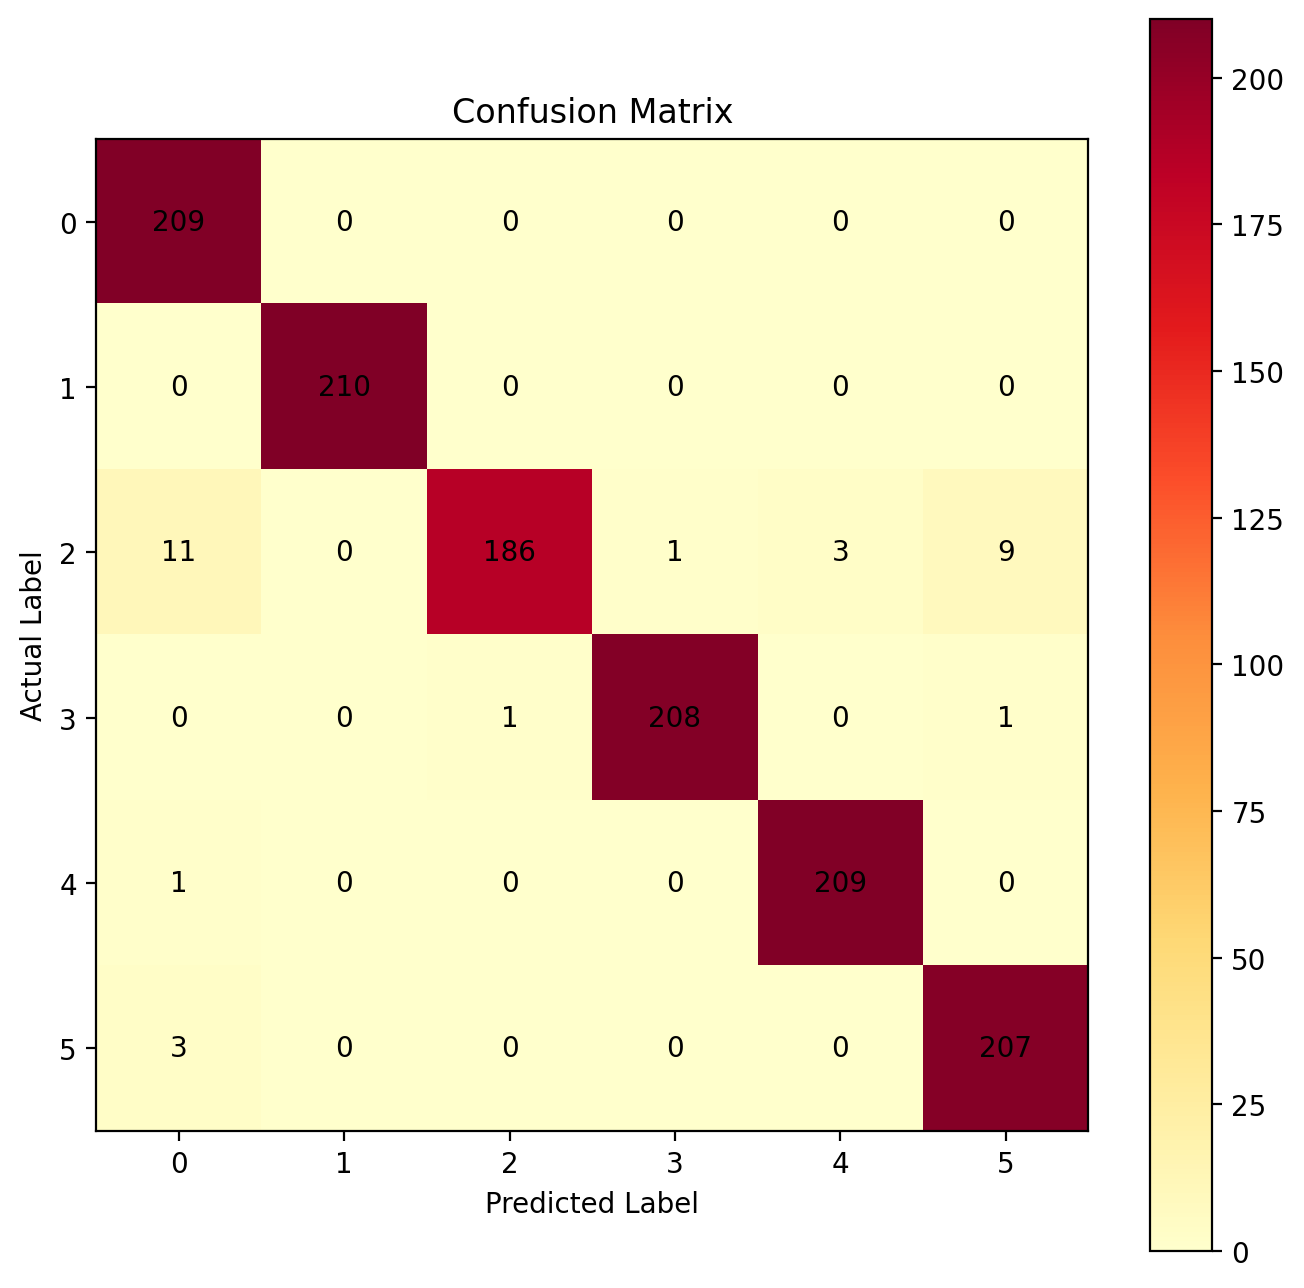

In [ ]:
plot_confusion_matrix(train_confusion)

In [ ]:
train_accuracy, train_precision, train_recall, train_f1, train_confusion = evaluate(model_transfer, trainloader, use_cuda)
validation_accuracy, validation_precision, validation_recall, validation_f1, validation_confusion = evaluate(model_transfer, validloader, use_cuda)
test_accuracy, test_precision, test_recall, test_f1, test_confusion = evaluate(model_transfer, testloader, use_cuda)

# Print the evaluation metrics
print("Train Set Metrics:")
print(f"Accuracy: {train_accuracy}")
print(f"Precision: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1 Score: {train_f1}")
print("Confusion Matrix:")
print(train_confusion)

print("\nValidation Set Metrics:")
print(f"Accuracy: {validation_accuracy}")
print(f"Precision: {validation_precision}")
print(f"Recall: {validation_recall}")
print(f"F1 Score: {validation_f1}")
print("Confusion Matrix:")
print(validation_confusion)

print("\nTest Set Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1}")
print("Confusion Matrix:")
print(test_confusion)

Train Set Metrics:
Accuracy: 0.9761715647339158
Precision: 0.9771115898337716
Recall: 0.9761904761904763
F1 Score: 0.9758836888474031
Confusion Matrix:
[[209   0   0   0   0   0]
 [  0 210   0   0   0   0]
 [ 11   0 186   1   3   9]
 [  0   0   1 208   0   1]
 [  1   0   0   0 209   0]
 [  3   0   0   0   0 207]]

Validation Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[ 42   0]
 [  0 209]]

Test Set Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[1]]


Epoch: 1 	Training Loss: 0.10432 	Validation Loss: 0.00333
Validation loss decreased (inf --> 0.00333). Saving model ...
Epoch: 2 	Training Loss: 0.08441 	Validation Loss: 0.00484
Epoch: 3 	Training Loss: 0.08585 	Validation Loss: 0.02430
Epoch: 4 	Training Loss: 0.06539 	Validation Loss: 0.09337
Epoch: 5 	Training Loss: 0.06564 	Validation Loss: 0.00067
Validation loss decreased (0.00333 --> 0.00067). Saving model ...
Epoch: 6 	Training Loss: 0.06886 	Validation Loss: 0.00915
Epoch: 7 	Training Loss: 0.04125 	Validation Loss: 0.05253
Epoch: 8 	Training Loss: 0.04850 	Validation Loss: 0.02405
Epoch: 9 	Training Loss: 0.04622 	Validation Loss: 0.01310
Epoch: 10 	Training Loss: 0.03344 	Validation Loss: 0.00383


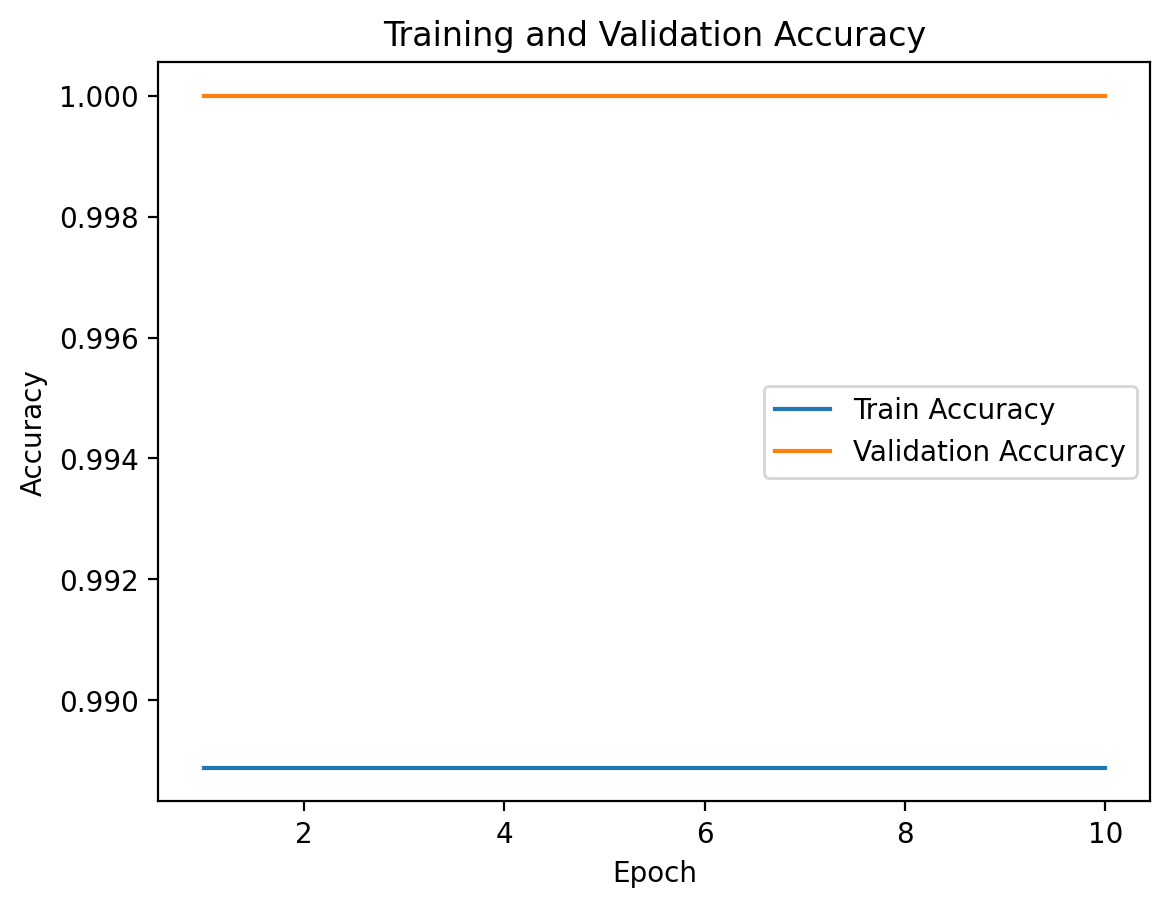

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define classes
class_names = ['200', '500', '1000', '2000']

# Define the evaluation function
def evaluate(model, dataloader, use_cuda):
    model.eval()

    correct = 0
    total = 0

    # Iterate over the data
    for batch_idx, (data, target) in enumerate(dataloader):
        # Move data to GPU if available
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # Forward pass
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)

        # Update correct predictions
        total += target.size(0)
        correct += (predicted == target).sum().item()

    # Calculate accuracy
    accuracy = correct / total
    return accuracy

# Define loaders transfer
loaders_transfer = {'train': trainloader,
                    'valid': validloader,
                    'test': testloader}

# Train the model
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# Evaluate on train, validation, and test sets
train_accuracy = evaluate(model_transfer, trainloader, use_cuda)
validation_accuracy = evaluate(model_transfer, validloader, use_cuda)
test_accuracy = evaluate(model_transfer, testloader, use_cuda)

# Plot train and validation accuracy
epochs = range(1, 11)
train_accuracy_values = [train_accuracy] * 10
validation_accuracy_values = [validation_accuracy] * 10

plt.plot(epochs, train_accuracy_values, label='Train Accuracy')
plt.plot(epochs, validation_accuracy_values, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()
